In [1]:
import gdown
import glob
import folium
import pandas as pd
import os
import numpy as np
import datetime 
import seaborn as sns
from matplotlib import pyplot as plt
from pylab import *
import geopandas as gpd
from sklearn.linear_model import LinearRegression

**Load Mean Temperature Data For Stations.**

In [2]:
temp_filename = 'https://raw.githubusercontent.com/ielattar/Climate-Change/main/data/mean_temp.csv'
temp_df = pd.read_csv(temp_filename,engine='python').reset_index()
temp_df.drop(temp_df.columns[[1]], axis=1, inplace=True)
temp_df=temp_df.replace(-9999.9, np.nan)
temp_df=temp_df.dropna(axis=0, subset=['mean-temp(celsius)'])
temp_df

,index,year,mean-temp(celsius),stnid,Station name,Prov,%Miss,Lat(deg),Long(deg),Elev(m),Joined,RCS
1,1,1914,4.1,1012010,COWICHAN_BAY_CHERRY_,BC,7.7,48.7,-123.5,0,n,n
2,2,1915,3.7,1012010,COWICHAN_BAY_CHERRY_,BC,7.7,48.7,-123.5,0,n,n
3,3,1916,1.2,1012010,COWICHAN_BAY_CHERRY_,BC,7.7,48.7,-123.5,0,n,n
4,4,1917,2.1,1012010,COWICHAN_BAY_CHERRY_,BC,7.7,48.7,-123.5,0,n,n
5,5,1918,3.7,1012010,COWICHAN_BAY_CHERRY_,BC,7.7,48.7,-123.5,0,n,n
...,...,...,...,...,...,...,...,...,...,...,...,...
62063,62063,2014,-22.5,8504177,WABUSH_LAKE,NFLD,0.8,52.9,-66.8,55,y,y
62064,62064,2015,-23.5,8504177,WABUSH_LAKE,NFLD,0.8,52.9,-66.8,55,y,y
62065,62065,2016,-17.6,8504177,WABUSH_LAKE,NFLD,0.8,52.9,-66.8,55,y,y
62066,62066,2017,-19.9,8504177,WABUSH_LAKE,NFLD,0.8,52.9,-66.8,55,y,y


**Find the Three Top Most Stations with highest record count by Province.**

In [3]:
temp_df_count=temp_df.groupby(['Prov','Station name']).size().sort_values(ascending=False).reset_index(name='count') 
sample_stations_df=temp_df_count.groupby('Prov').head(3)


**Filter The Mean Temperature Data Frame to only include the readings of the top stations.**

In [4]:
names_list = sample_stations_df['Station name'].values.tolist() 
name_list_str=','.join(names_list)
#print(name_list_str)
filtered_temp_df = temp_df[temp_df['Station name'].isin(names_list)]
filtered_temp_df.head(5)

,index,year,mean-temp(celsius),stnid,Station name,Prov,%Miss,Lat(deg),Long(deg),Elev(m),Joined,RCS
637,637,1899,2.4,1018621,VICTORIA,BC,0.3,48.6,-123.4,2,y,n
638,638,1900,4.5,1018621,VICTORIA,BC,0.3,48.6,-123.4,2,y,n
639,639,1901,4.1,1018621,VICTORIA,BC,0.3,48.6,-123.4,2,y,n
640,640,1902,4.5,1018621,VICTORIA,BC,0.3,48.6,-123.4,2,y,n
641,641,1903,3.5,1018621,VICTORIA,BC,0.3,48.6,-123.4,2,y,n


**Create a 2D scatterplot with an overlaid regression line For temperature over time per Province**

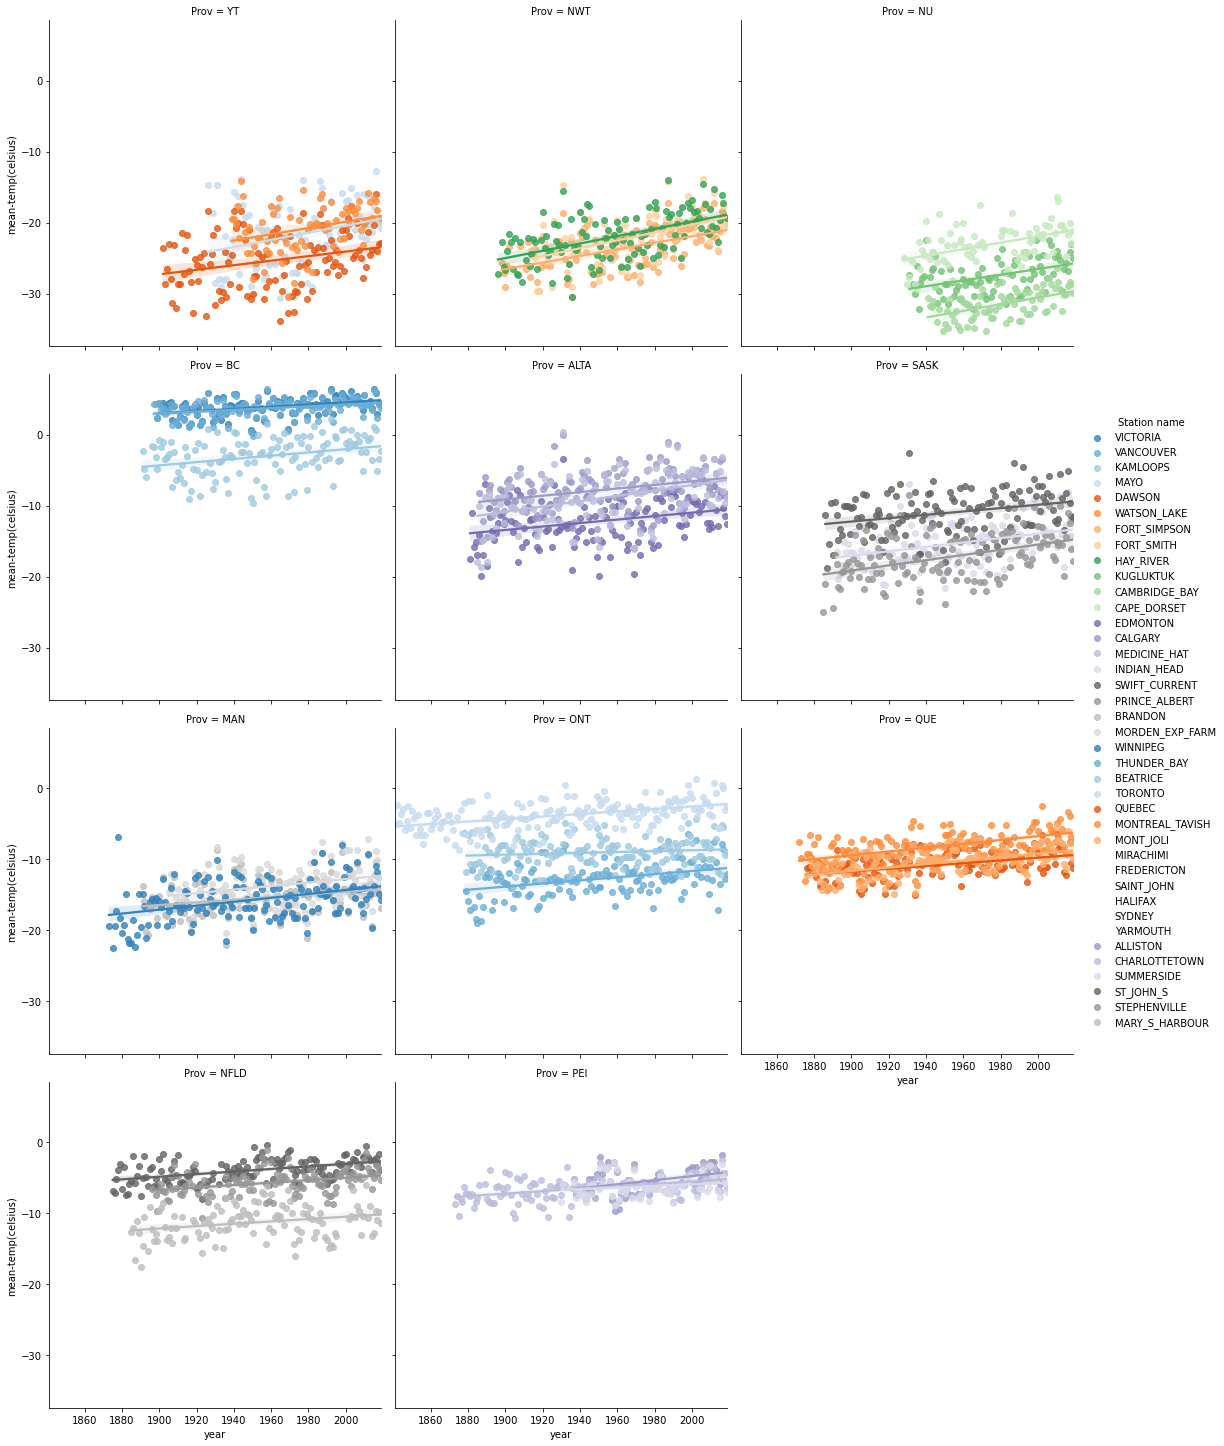

In [5]:
chart=sns.lmplot(
            x='year',
            y='mean-temp(celsius)',
            data=filtered_temp_df,
            col='Prov',
            hue='Station name',
            legend_out=True,
            palette="tab20c",
            col_wrap=3,
            col_order=["YT","NWT","NU","BC","ALTA","SASK","MAN","ONT","QUE","NFLD","PEI"]
        )
plt.show()
chart.savefig("d:\\temp\\temp.png")

**Ceate a 2D line plot showing temperature trends over time per Province**

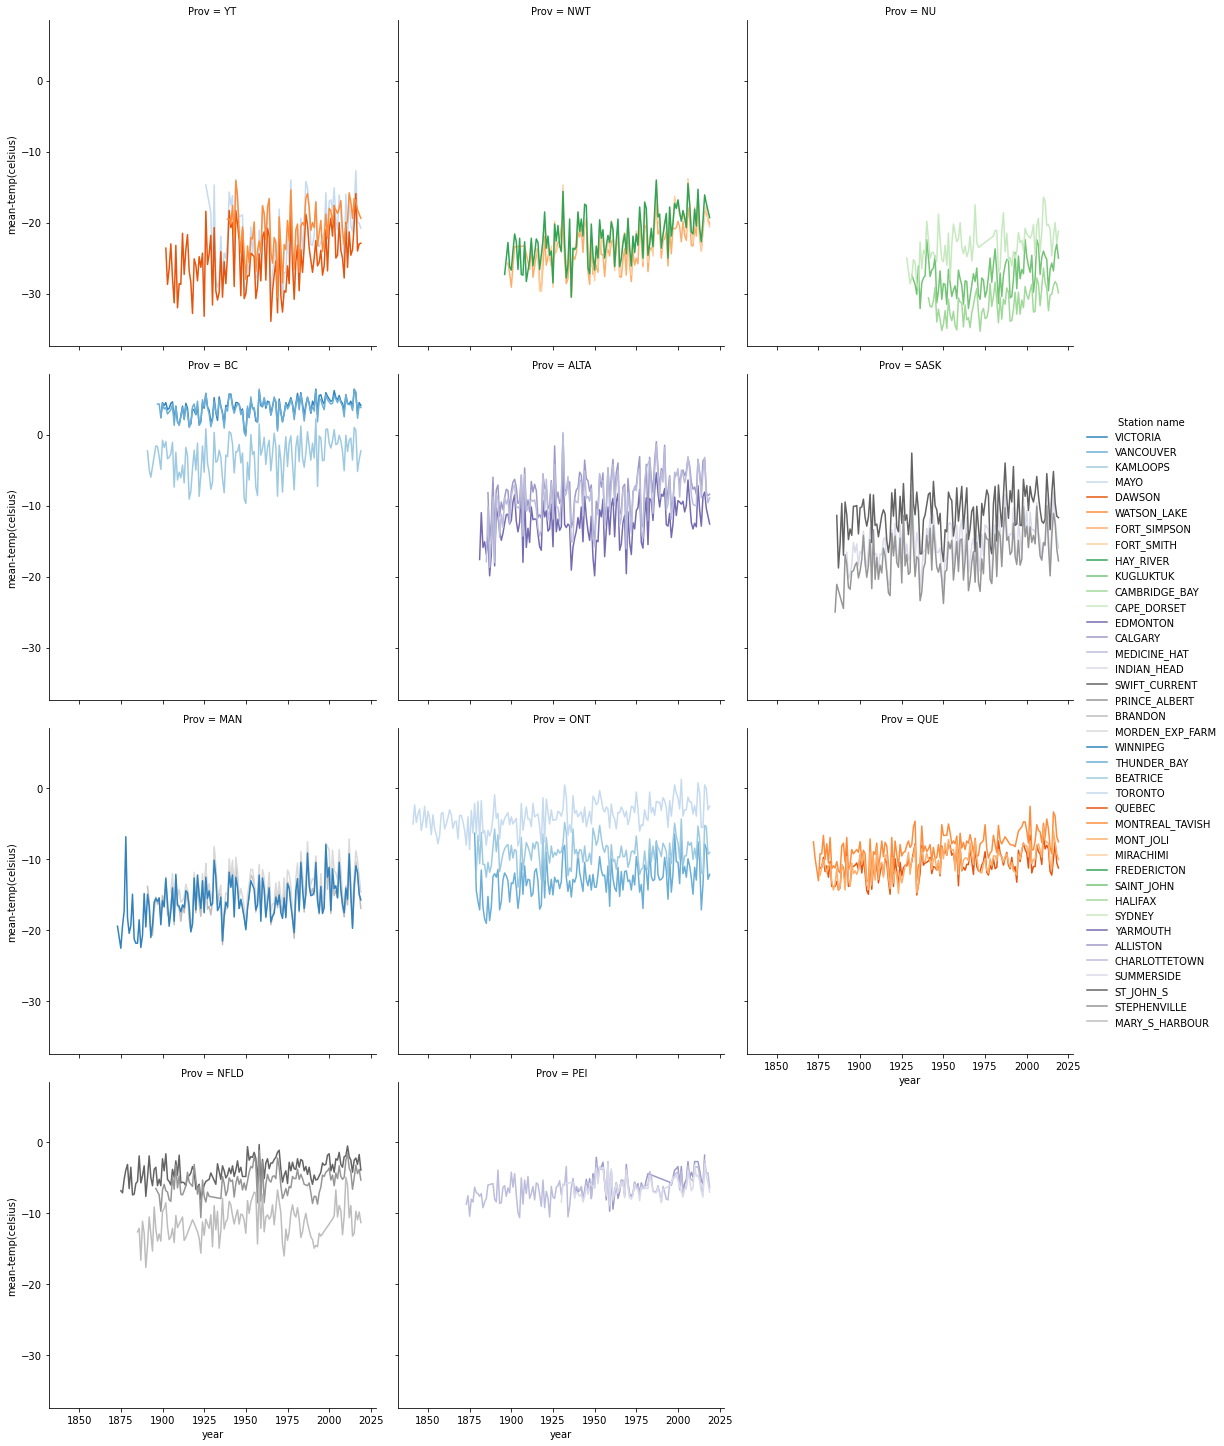

In [6]:
chart=sns.relplot(
            x='year',
            y='mean-temp(celsius)',
            data=filtered_temp_df,
            col='Prov',
            hue='Station name',
            kind="line",
            palette="tab20c",
            col_wrap=3,
            col_order=["YT","NWT","NU","BC","ALTA","SASK","MAN","ONT","QUE","NFLD","PEI"]
        )
plt.show()

In [7]:
stations_df=filtered_temp_df.groupby('Prov').apply(lambda df: df.sample(1))
names_list = stations_df['Station name'].values.tolist() 
name_list_str=','.join(names_list)
sampled_stations_df = filtered_temp_df[filtered_temp_df['Station name'].isin(names_list)]
sampled_stations_df= sampled_stations_df[['year','Station name','mean-temp(celsius)']]


**Fetch Top Six Station readings from each province**

In [8]:
temp_df_count=temp_df.groupby(['Prov','Station name']).size().sort_values(ascending=False).reset_index(name='count') 
sample_stations_df=temp_df_count.groupby('Prov').head(6)
names_list = sample_stations_df['Station name'].values.tolist() 
name_list_str=','.join(names_list)
#print(name_list_str)
filtered_temp_df = temp_df[temp_df['Station name'].isin(names_list)]

**Calculate mean averages by decade per station and create a heat map per province**

<Figure size 432x288 with 0 Axes>

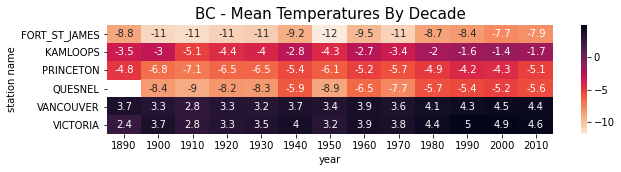

<Figure size 432x288 with 0 Axes>

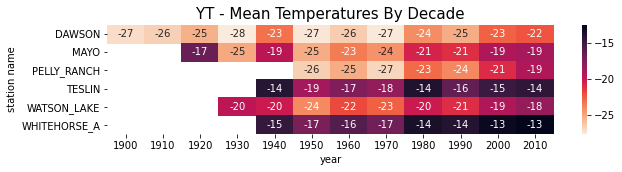

<Figure size 432x288 with 0 Axes>

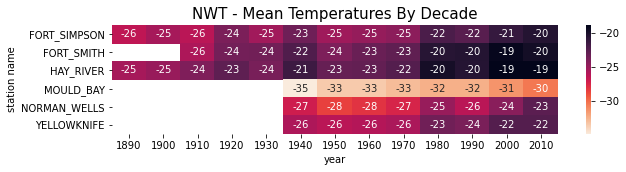

<Figure size 432x288 with 0 Axes>

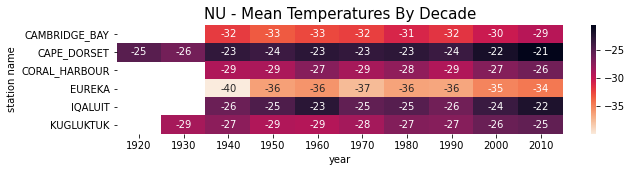

<Figure size 432x288 with 0 Axes>

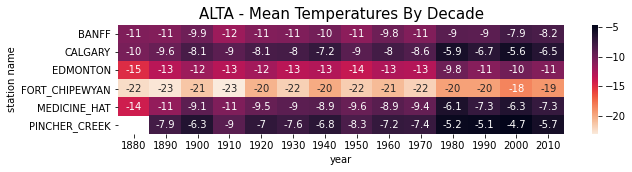

<Figure size 432x288 with 0 Axes>

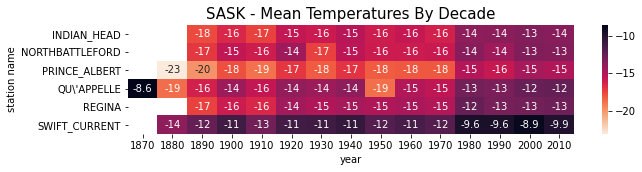

<Figure size 432x288 with 0 Axes>

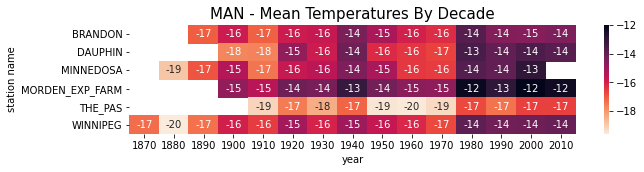

<Figure size 432x288 with 0 Axes>

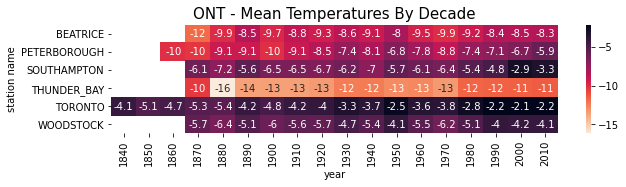

<Figure size 432x288 with 0 Axes>

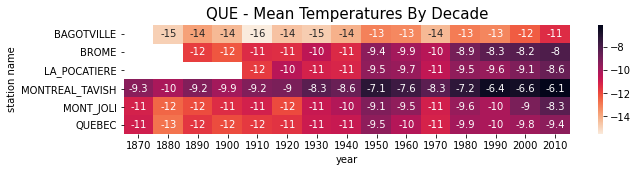

<Figure size 432x288 with 0 Axes>

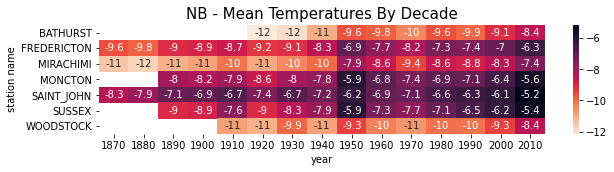

<Figure size 432x288 with 0 Axes>

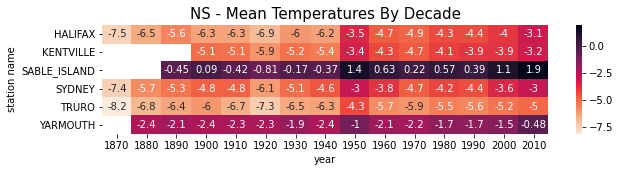

<Figure size 432x288 with 0 Axes>

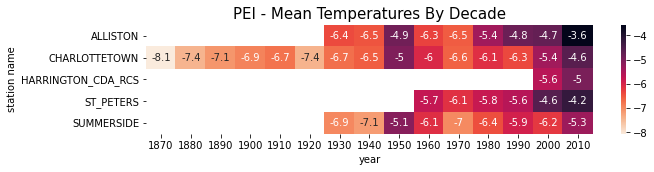

<Figure size 432x288 with 0 Axes>

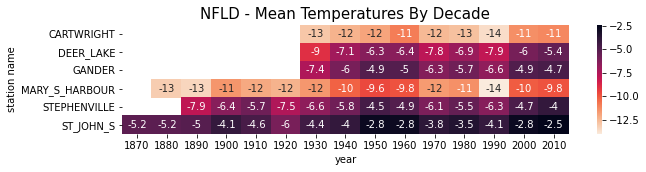

In [9]:
plt.rcParams.update({'figure.max_open_warning': 0})
resampled_data = []
provinces_list= filtered_temp_df['Prov'].unique().tolist() 
for aProvince in provinces_list:
    queryString="`Prov`=='"+ aProvince + "'"
    province_temp_df=filtered_temp_df.query(queryString)
    stations_list = province_temp_df['Station name'].unique().tolist() 
    for aStation in stations_list:
        aStation=re.sub("'", "\\'",aStation)
        queryString="`Station name`=='"+ aStation + "'"
        station_temp_df=province_temp_df.query(queryString)
        station_temp_df= station_temp_df[['year','mean-temp(celsius)']]
        station_temp_df=station_temp_df.set_index('year')
        station_temp_df.index=pd.to_datetime(station_temp_df.index,format='%Y')
        station_decade_df=station_temp_df.groupby(station_temp_df.index.year // 10 * 10).mean()
        #station_decade_df=station_temp_df.resample('10AS').mean()
        #sns.lineplot(data=station_decade_df, x="year", y="mean-temp(celsius)")
        station_decade_df['station name'] = aStation 
        #print(station_decade_df)
        #station_decade_df=station_decade_df.dropna()
        resampled_data.append(station_decade_df)
    resampled_temp_df = pd.concat(resampled_data)
    resampled_temp_df.reset_index()
    cmap = sns.cm.rocket_r
    pivoted_df=resampled_temp_df.pivot_table(index='station name', columns='year', values='mean-temp(celsius)')
    plt.figure()
    plt.subplots(figsize=(10,2))
    sns.heatmap(pivoted_df,annot=True,cmap = cmap)    
    plt.title(  aProvince + ' - Mean Temperatures By Decade' , fontsize=15) 
    resampled_data=[]
    del aProvince    
    


**Loop through the stations and calculate regression slope and the difference between oldest and most recent Winter Temperature reading.**

In [10]:
column_names = ["station_id","station_name","province" ,"difference","intercept","slope"]
range_slope_df = pd.DataFrame(columns = column_names)

stn_prov_df=temp_df[["stnid",'Prov','Station name']].drop_duplicates()
stnid_list = stn_prov_df['stnid'].unique().tolist() 
for stnid in stnid_list:
    #lookup the station province
    stn_prov=stn_prov_df.loc[stn_prov_df['stnid'] == stnid, 'Prov'].iloc[0]
    stn_name=stn_prov_df.loc[stn_prov_df['stnid'] == stnid, 'Station name'].iloc[0]
    #fetch all the station records from the temp_df
    station_records=temp_df[temp_df["stnid"] == stnid]
    #print (station_records)
    #Calculate the difference.
    minyear=station_records['year'].min()
    maxyear=station_records['year'].max()   
    minyearTemp=station_records.loc[station_records['year'] == minyear, 'mean-temp(celsius)'].iloc[0]
    maxyearTemp=station_records.loc[station_records['year'] == maxyear, 'mean-temp(celsius)'].iloc[0]
    diff=maxyearTemp-minyearTemp
    #print(diff)
    model=LinearRegression(fit_intercept=True)
    x=station_records['year'].values.reshape(-1,1)
    #print(x)
    y=station_records['mean-temp(celsius)'].values
    #print(y.values)
    model.fit(x,y)
    intercept=model.intercept_
    slope=model.coef_[0]
    #Calculate the corrolation.
    new_row = {'station_id':stnid,'station_name':stn_name, 'province':stn_prov, 'temperature_difference':diff , 'intercept':intercept,'slope':slope}
    range_slope_df  = range_slope_df.append(new_row, ignore_index=True)
    



In [11]:
#sns.scatterplot(data= range_slope_df , x="temperature_difference", y="slope" , hue="province", style="province" )
#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

**Calculate average slope and average winter temperature difference by province**

In [12]:
averages_df=range_slope_df[["province","slope","temperature_difference"]].groupby("province").mean()
averages_df=averages_df.reset_index()
averages_df=averages_df.sort_values(by=['slope'])
averages_df['slope'] = averages_df['slope'].multiply(100)
averages_df=averages_df.replace(['YT','ALTA','NFLD','NU','QUE','NWT','MAN','NB','SASK','NS','PEI','BC','ONT'], 
                                ['Yukon','Alberta',
                                 'Newfoundland',
                                 'Nunavut','Quebec','Northwest Territories',
                                 'Manitoba','New Brunswick',
                                'Saskatchewan','Nova Scotia','Prince Edward Island','British Columbia','Ontario'])


In [13]:
slopes_df=averages_df.sort_values(by=['slope'],ascending=[False])
slopes_df=slopes_df.iloc[:,0:2]
slopes_df

,province,slope
12,Yukon,7.885705
7,Northwest Territories,6.126273
2,Manitoba,4.006622
4,Newfoundland,3.929463
11,Saskatchewan,3.376821
9,Prince Edward Island,2.346315
8,Ontario,2.277866
1,British Columbia,2.185562
10,Quebec,2.185514
5,Nova Scotia,2.118338


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]),
 [Text(0, 0, 'Nunavut'),
  Text(1, 0, 'Saskatchewan'),
  Text(2, 0, 'New Brunswick'),
  Text(3, 0, 'Newfoundland'),
  Text(4, 0, 'Quebec'),
  Text(5, 0, 'British Columbia'),
  Text(6, 0, 'Nova Scotia'),
  Text(7, 0, 'Alberta'),
  Text(8, 0, 'Ontario'),
  Text(9, 0, 'Manitoba'),
  Text(10, 0, 'Yukon'),
  Text(11, 0, 'Prince Edward Island'),
  Text(12, 0, 'Northwest Territories')])

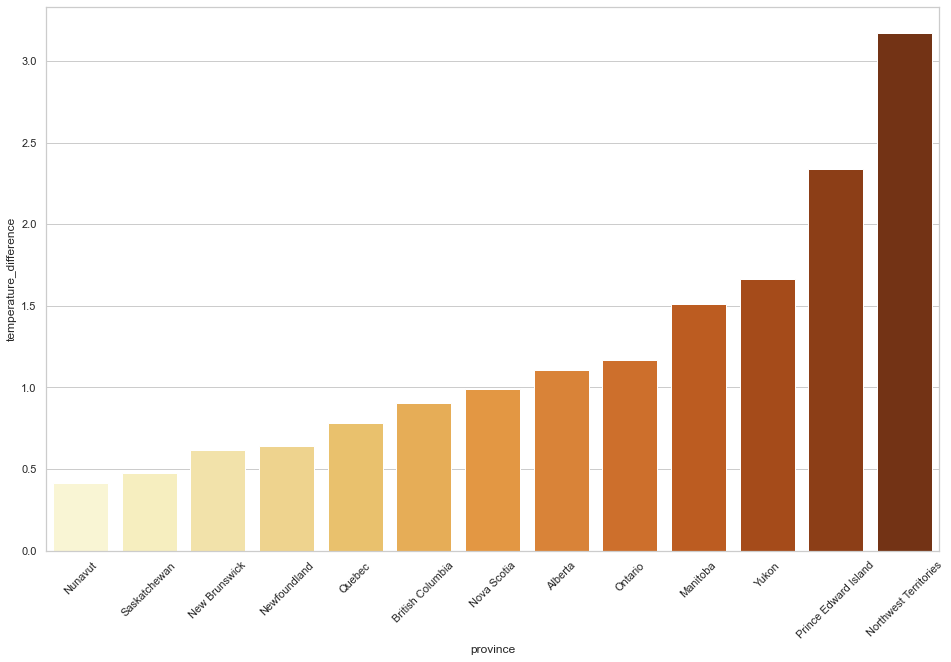

In [14]:
sns.set_theme(style="whitegrid")

plt.figure(figsize=(16, 10))
ax = sns.barplot(x="province",
                 y="temperature_difference",
                 data=averages_df,
                 order=averages_df.sort_values('temperature_difference').province,
                 palette="YlOrBr")
plt.xticks(rotation=45)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]),
 [Text(0, 0, 'Alberta'),
  Text(1, 0, 'New Brunswick'),
  Text(2, 0, 'Nunavut'),
  Text(3, 0, 'Nova Scotia'),
  Text(4, 0, 'Quebec'),
  Text(5, 0, 'British Columbia'),
  Text(6, 0, 'Ontario'),
  Text(7, 0, 'Prince Edward Island'),
  Text(8, 0, 'Saskatchewan'),
  Text(9, 0, 'Newfoundland'),
  Text(10, 0, 'Manitoba'),
  Text(11, 0, 'Northwest Territories'),
  Text(12, 0, 'Yukon')])

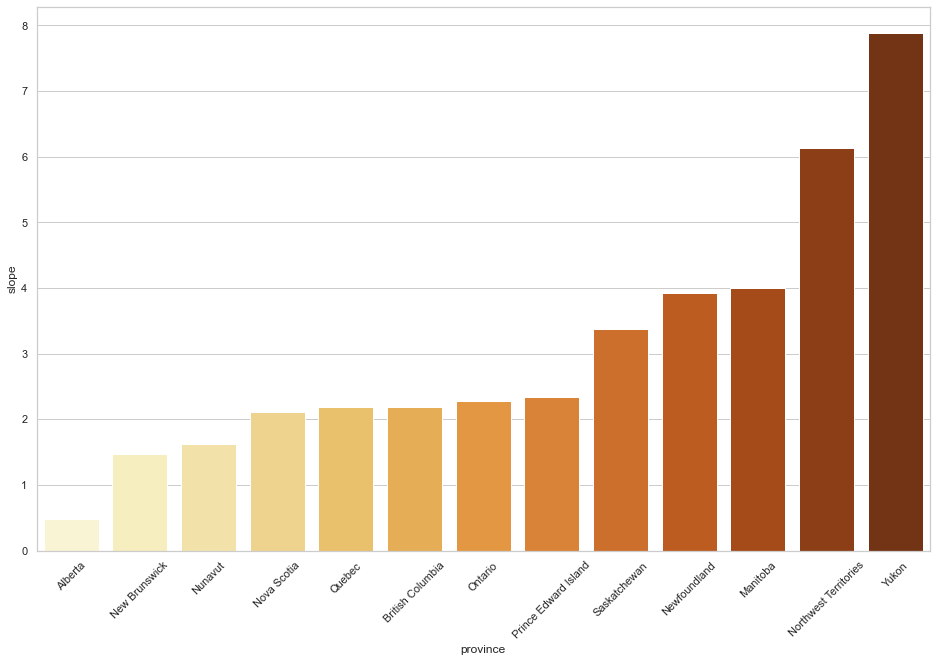

In [15]:
sns.set_theme(style="whitegrid")
averages_df=averages_df.reset_index()
plt.figure(figsize=(16, 10))
ax = sns.barplot(x="province",
                 y="slope",
                 data=averages_df,
                 order=averages_df.sort_values('slope').province,
                 palette="YlOrBr")
plt.xticks(rotation=45)


In [16]:
df_provinces = gpd.read_file('https://raw.githubusercontent.com/ielattar/Climate-Change/main/data/canada_provinces.geojson')


In [17]:
df_provinces=df_provinces.rename(columns={"PRENAME": "province"})
averages_df=averages_df.replace(['Newfoundland'],['Newfoundland and Labrador'])
df_provinces = df_provinces.merge(averages_df, on='province')




Text(0.5, 1.0, 'Rate of Temperature Rise By Province (1840 - 2020)')

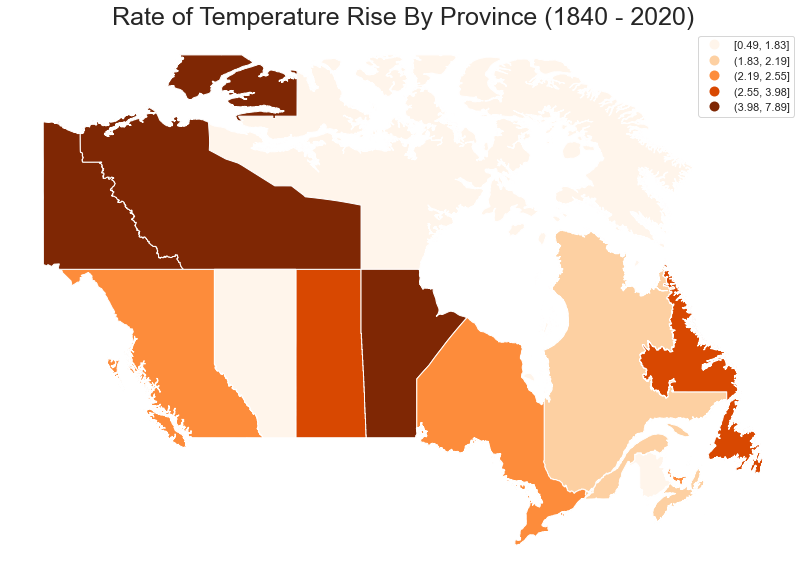

In [18]:
ax = df_provinces.plot(figsize=(20, 10), column='slope',cmap='Oranges',scheme='Quantiles',legend=True)
ax.axis('off')
# add a title
ax.set_title('Rate of Temperature Rise By Province (1840 - 2020)', fontdict={'fontsize': '25', 'fontweight' : '3'})

Text(0.5, 1.0, 'Degrees of Temperature Rise by Province (1840 - 2020)')

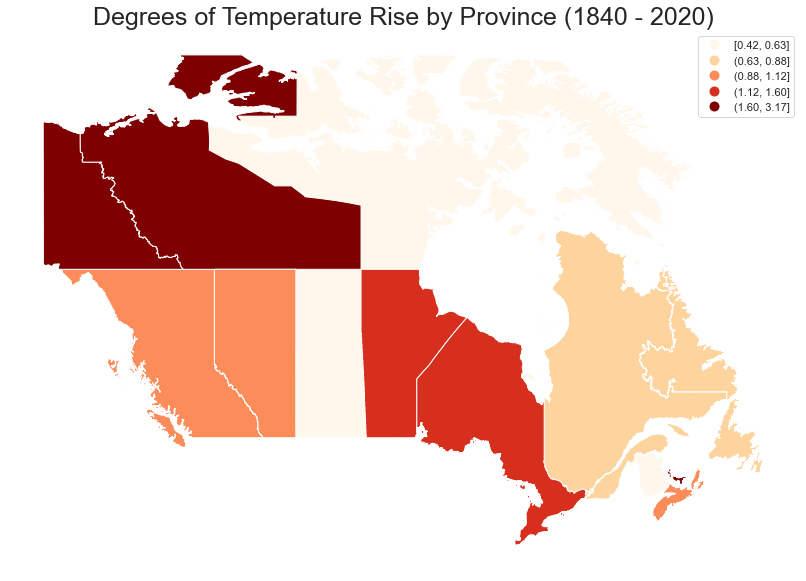

In [19]:
ax = df_provinces.plot(figsize=(20, 10), column='temperature_difference',cmap='OrRd',scheme='Quantiles',legend=True)
ax.axis('off')
# add a title
ax.set_title('Degrees of Temperature Rise by Province (1840 - 2020)', fontdict={'fontsize': '25', 'fontweight' : '3'})